<a href="https://colab.research.google.com/github/Mrunalika9/Real-Time-Crop-Stress/blob/main/crop_stress_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00
Enter a location name (e.g., Punjab, India): Cleveland, Ohio
Latitude: 41.4996574, Longitude: -81.6936772
Fetching data from 20250324 to 20250408

📊 Sample Data:
        date  temperature   rainfall  humidity      ndvi stress_level
0   20250324         4.39   0.536838     74.74  0.573357     Moderate
1   20250325         2.77   4.582978     71.44  0.666803          Low
2   20250326         0.74   9.407625     69.07  0.290900     Moderate
3   20250327         4.33   5.613652     72.48  0.356584     Moderate
4   20250328         9.53   7.498403     84.93  0.762450          Low
5   20250329        13.36   0.333511     84.84  0.563447     Moderate
6   20250330        12.09   9.815424

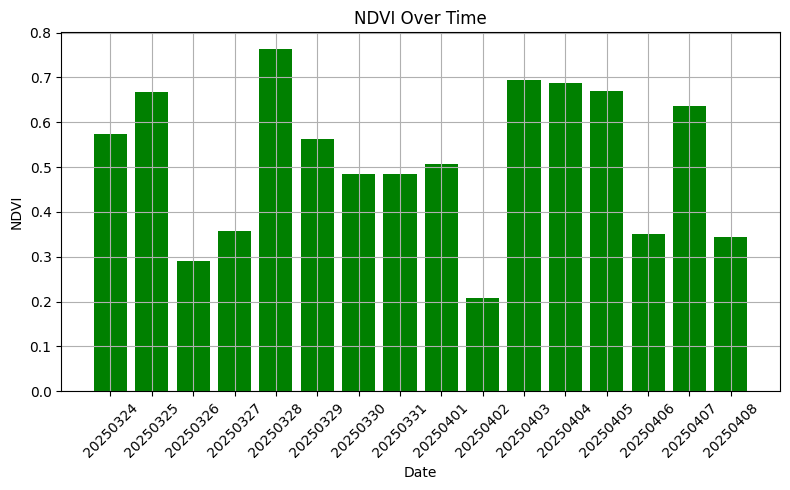

In [3]:
!pip install streamlit -q

# 📦 Import Libraries
import requests
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

st.title("Crop Stress Detection")
# Function to fetch coordinates
def get_coordinates(location_name):
    try:
        geolocator = Nominatim(user_agent="chaitu_crop_stress_detector")
        location = geolocator.geocode(location_name, timeout=10)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Geocoding error: {e}")
        return None, None

# 👇 Input location name
place = input("Enter a location name (e.g., Punjab, India): ")
LAT, LON = get_coordinates(place)

if LAT and LON:
    print(f"Latitude: {LAT}, Longitude: {LON}")
else:
    print("Location not found. Exiting.")
    exit()
# Define date range
end_date = datetime.today()
start_date = end_date - timedelta(days=15)

START_DATE = start_date.strftime('%Y%m%d')
END_DATE = end_date.strftime('%Y%m%d')

print(f"Fetching data from {START_DATE} to {END_DATE}")
# NASA POWER API URL
NASA_API = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
    f"parameters=T2M,RH2M&community=AG&longitude={LON}"
    f"&latitude={LAT}&start={START_DATE}&end={END_DATE}&format=JSON"
)

# Make API call
response = requests.get(NASA_API)
data = response.json()

# Validate response
if 'properties' not in data or 'parameter' not in data['properties']:
    raise ValueError("Invalid API response. Check location or date range.")

# Parse data
daily_data = data['properties']['parameter']
dates = list(daily_data['T2M'].keys())
ndvi_values = np.random.uniform(0.2, 0.9, size=len(dates))  # Simulated NDVI values

# Create records with synthetic rain & stress classification
records = []
for i, date in enumerate(dates):
    temp = daily_data['T2M'][date]
    humidity = daily_data['RH2M'][date]
    ndvi = ndvi_values[i]
    rain = np.random.uniform(0, 15)

    if ndvi < 0.3 and temp > 35:
        stress = 'High'
    elif ndvi > 0.6:
        stress = 'Low'
    else:
        stress = 'Moderate'

    records.append({
        "date": date,
        "temperature": temp,
        "rainfall": rain,
        "humidity": humidity,
        "ndvi": ndvi,
        "stress_level": stress
    })

# Convert to DataFrame
df = pd.DataFrame(records)
print("\n📊 Sample Data:")
print(df)

# Prepare features and label
X = df[["temperature", "rainfall", "humidity", "ndvi"]]
y = df["stress_level"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Classification report with only present classes
labels_present = unique_labels(y_test, predictions)
target_names_present = label_encoder.inverse_transform(labels_present)

print("\n📋 Classification Report:")
print(classification_report(
    y_test, predictions,
    labels=labels_present,
    target_names=target_names_present,
    zero_division=0
))

# Predict for latest input row
latest_input = df.iloc[[-1]][["temperature", "rainfall", "humidity", "ndvi"]]
predicted_encoded = model.predict(latest_input)
predicted_stress = label_encoder.inverse_transform(predicted_encoded)

print(f"\n🌾 Predicted Stress Level for {df.iloc[-1]['date']}: {predicted_stress[0]}")

# Plot NDVI
plt.figure(figsize=(8,5))
plt.bar(df['date'], df['ndvi'], color='green')
plt.title('NDVI Over Time')
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

